<a href="https://colab.research.google.com/github/HoomanKhosravi/ImageSegmentation_Human_PyTourch_Unet/blob/main/ImageSegmentation_Human_PyTourch_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations

     |████████████████████████████████| 87 kB 4.9 MB/s 
     |████████████████████████████████| 376 kB 17.4 MB/s 
     |████████████████████████████████| 58 kB 6.0 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=078183dea14db9f0ed6775004bbe9b24f567ae3db074567eaacabd783bf006f4
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=55e548d3e1a6ceeacf1ac226e0fe216603d99f2ccbcd6886bb2bff729a081442
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-49hhjmrj
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-49hhjmrj
   

#Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [3]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 9.95 MiB/s, done.
Resolving deltas: 100% (3/3), done.


#Imports

In [4]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [5]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

#Setup Configurations

In [6]:
TRAIN_CSV = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content'

DEVICE = 'cuda'

EPOCHS = 25
LEARNING_RATE = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'



In [7]:
df = pd.read_csv(TRAIN_CSV)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [8]:
row = df.iloc[1]
mask_dir = row.masks
image_dir = row.images

image = cv2.imread(image_dir)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_dir, cv2.IMREAD_GRAYSCALE)/ 255.0 

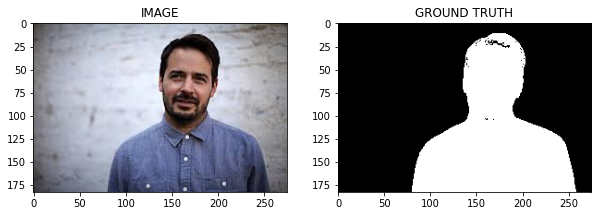

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [10]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 32)


#Augmentation

albumentation documentation : https://albumentations.ai/docs/

In [11]:
import albumentations as alb

In [12]:
def get_train_augs():
  return alb.Compose([
    alb.Resize(IMAGE_SIZE, IMAGE_SIZE),
    alb.HorizontalFlip(p = 0.5),
    alb.VerticalFlip(p = 0.5)
  ])
def get_valid_augs():
  return alb.Compose([
    alb.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ])



#Create Custom Dataset 

In [13]:
from torch.utils.data import Dataset

In [14]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    
    mask_dir = row.masks
    image_dir = row.images

    image = cv2.imread(image_dir)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_dir, cv2.IMREAD_GRAYSCALE) 
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']
    
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image)/ 255.0
    mask = torch.round( torch.Tensor(mask)/255.0 )

    return image, mask




In [15]:
train_set = SegmentationDataset( train_df, get_train_augs()) 
valid_set = SegmentationDataset( valid_df, get_valid_augs())

In [16]:
print(f"Size of Trainset : {len(train_set)}")
print(f"Size of Validset : {len(valid_set)}")

Size of Trainset : 232
Size of Validset : 58


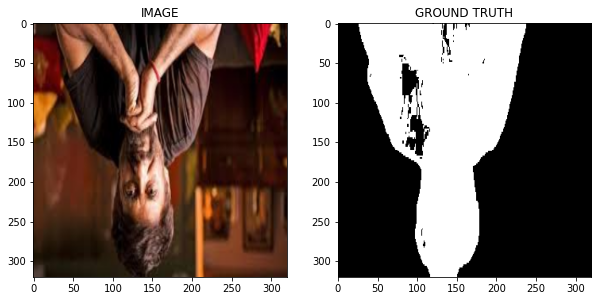

In [17]:
idx = 1
image, mask = train_set[idx]

helper.show_image(image, mask)

#Load dataset into batches

In [18]:
from torch.utils.data import DataLoader

In [19]:
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle= True)
validloader = DataLoader(valid_set, batch_size=BATCH_SIZE)


In [20]:
print(f"total # of batches in trainloader : {len(trainloader)}")
print(f"total # of batches in validloader : {len(validloader)}")

total # of batches in trainloader : 15
total # of batches in validloader : 4


#Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [30]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )
  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2
    return logits

In [33]:
model = SegmentationModel();
model.to(DEVICE);

#Create Train and Validation Function 

In [34]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logtis, loss = model(images, masks)
    loss.backward()
    optimizer.step()
    
    total_loss += loss.item()

  return total_loss / len(data_loader)
  

In [38]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      
      logtis, loss = model(images, masks)
      
      
      
      total_loss += loss.item()

  return total_loss / len(data_loader)

#Train Model

In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [ ]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
  
  train_loss = train_fn(trainloader ,model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('Best Model Saved!')
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} Train Loss : {train_loss} Valid_loss : {valid_loss}")

#Inference

In [61]:
image = cv2.imread('/content/DSC_1034.jpg')
image = cv2.resize(image, [IMAGE_SIZE, IMAGE_SIZE], interpolation = cv2.INTER_AREA)

image = np.transpose(image, (2,0,1)).astype(np.float32)
image = torch.Tensor(image)/ 255.0


In [62]:
idx = 1

model.load_state_dict(torch.load('/content/best_model.pt'))

#image, mask = valid_set[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))

pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*0.1

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))